In [1]:
%pylab inline
#loading ipython cython extension
%load_ext Cython


Populating the interactive namespace from numpy and matplotlib


Reimplementing all in cython for speed optimisation:
For this every function has to be in the same block for cython magic (%%cython) to work

In [60]:
%%cython

cdef double beta = 100. # inverse temperature
cdef double t = 1. # energy scale for cubic lattice
cdef double D = 1. # energy scale for bethe lattice
import numpy as np
cimport numpy as np
#definition of FourierTransforms
cdef matsubara_fft(np.ndarray G_tau):
    cdef int N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
cdef np.ndarray matsubara_fft_trick(np.ndarray G_tau):
    cdef int N = G_tau.shape[0]
    cdef np.ndarray freq = matsubara_freq(N)
    cdef np.ndarray k = np.arange(N, dtype=np.float128)
    return beta/N*np.fft.fft( (G_tau+0.5) *np.exp(1j*np.pi*k/N)) + 1./(1j*freq)
#numpy orders frequencies differently so one has to convert frequencies
cdef np.ndarray matsubara_freq(int N):
    return np.pi/beta *(-2.*N*( np.array(np.fft.fftfreq(N),dtype=np.float128) ) +1.)
cdef np.ndarray matsubara_ifft(np.ndarray G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype=np.float128)
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
cdef np.ndarray matsubara_ifft_trick(G_omega):
    cdef int N = G_omega.shape[0]
    cdef np.ndarray freq = matsubara_freq(N)
    k = np.arange(N,dtype=np.float128)
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )

cdef int N = 500# number of imaginary frequencies
tau = np.linspace(0,beta*(1.-1./N),N) # discrete points in imaginary time
cdef double dtau = beta/N
freq = matsubara_freq(N) # matsubara frequencies, ordered according to np.fft


# second order self energy diagram
cdef np.ndarray self_energy(np.ndarray G0_omega,double U):
    cdef np.ndarray G0_tau = matsubara_ifft_trick(G0_omega)
    cdef np.ndarray integrand = np.zeros_like(G0_tau)

    integrand[0]= -U*U*G0_tau[0]**3
    cdef int N = G0_tau.shape[0]
    
    #if we define the index like this in cython, for loops are reduced to c-for loops and therefore way faster
    cdef int i
    for i in range(1,N):
        integrand[i] = U*U*G0_tau[i]**2*G0_tau[N-i]
    
    return matsubara_fft_trick(integrand)

# compute local Green's function from self energy given a disperion / density of states
# we can still use all normal python libraries (although possibly slower)
from scipy.integrate import simps
Ne = N
def dos_bethe(e):
    return 2./(np.pi*D)*np.sqrt(1.-(e/D)**2)
def dos_cubic(e):
    return 1./(t*np.sqrt(2.*np.pi))*np.exp(-e**2/(2.*t))
def Gloc_omega(self_energy_omega):
    #return 1./Nk*np.sum(1./(1j*freq-epsilon_k[:, np.newaxis]-self_energy_omega),axis=0)
    ##
    energies_bethe = np.linspace(-D,D,Ne)
    denergies_bethe = energies_bethe[2] - energies_bethe[1]
    return simps( dos_bethe(energies_bethe)/(1j*freq[:,np.newaxis]-energies_bethe-self_energy_omega[:,np.newaxis]) ,dx=denergies_bethe)
    ##
    #energies_cubic = np.linspace(-10.*t,10*t,Ne)
    #denergies_cubic = energies_cubic[2] - energies_cubic[1]
    #return simps( dos_cubic(energies_cubic)/(1j*freq[:,np.newaxis]-energies_cubic-self_energy_omega[:,np.newaxis]) ,dx=denergies_cubic)

# perform one loop from G0_initial to get new G0 and Gloc
def DMFT_loop(np.ndarray G0_initial_omega,double U,double frac_new, int iterations=1):
    cdef np.ndarray G0_omega= G0_initial_omega
    #use faster c for loop for iterations
    cdef int i
    for i in range(iterations):
        self_e = self_energy(G0_omega,U)
        Gloc = Gloc_omega(self_e)
        G0_omega = frac_new * 1./(1./Gloc+self_e+U/2.) + (1.-frac_new) * G0_omega
    return G0_omega, Gloc

In [65]:
%%cython
import numpy as np
cimport numpy as np
# use the Padé approximation to interpolate the Green's function
def get_a(np.ndarray points,np.ndarray values):  
    cdef int n = points.shape[0]
    g_mat = np.zeros((n,n),dtype=np.complex256)
    g_mat[0] = values
    
    cdef int i
    cdef int j
    for i in range(n-1): #filling the rest of the matrix using the recursion relation;
        for j in range(n-(i+1)):
            g_mat[i+1,i+1+j] = (g_mat[i,i]-g_mat[i,j+i+1])/((values[j+1+i]-values[i])*g_mat[i,j+i+1])

    return g_mat.diagonal()
def get_C(np.ndarray z,np.ndarray points,np.ndarray a_coeff):
    cdef int Na = points.shape[0]
    cdef int Nz = z.shape[0]
    A = np.zeros((Na+1,Nz),dtype=np.complex256)
    B = np.zeros((Na+1,Nz),dtype=np.complex256)
    A[1] = a_coeff[0]
    B[0] = 1.
    B[1] = 1.
    cdef int i
    for i in range(2,Na+1):
        A[i] = A[i-1] + (z-points[i-2]) * a_coeff[i-1] * A[i-2]
        B[i] = B[i-1] + (z-points[i-2]) * a_coeff[i-1] * B[i-2]
    return A[Na]/B[Na]

In [66]:
# fit various Green's functions and plot the spectral function
G0 = 1. / ( 1j*freq + 2. )
Glocs = []
U_list = np.array([0.2,0.6,1.,1.45,1.9])
numiter = 1
for U in U_list:
    g_0 = G0
    g_0, g_loc = DMFT_loop(g_0,U,0.7,iterations=numiter)
    Glocs.append(g_loc)

In [70]:
def shift_cut_symmetric(array, lower,upper,k):
    n = array.shape[0]
    interstep = 2*k+1
    a1 = np.fft.fftshift(array)[n/2+k+1:upper:interstep]
    a2 = np.fft.fftshift(array)[n/2-k:lower:-interstep]
    return np.concatenate((a2,a1))

/data/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


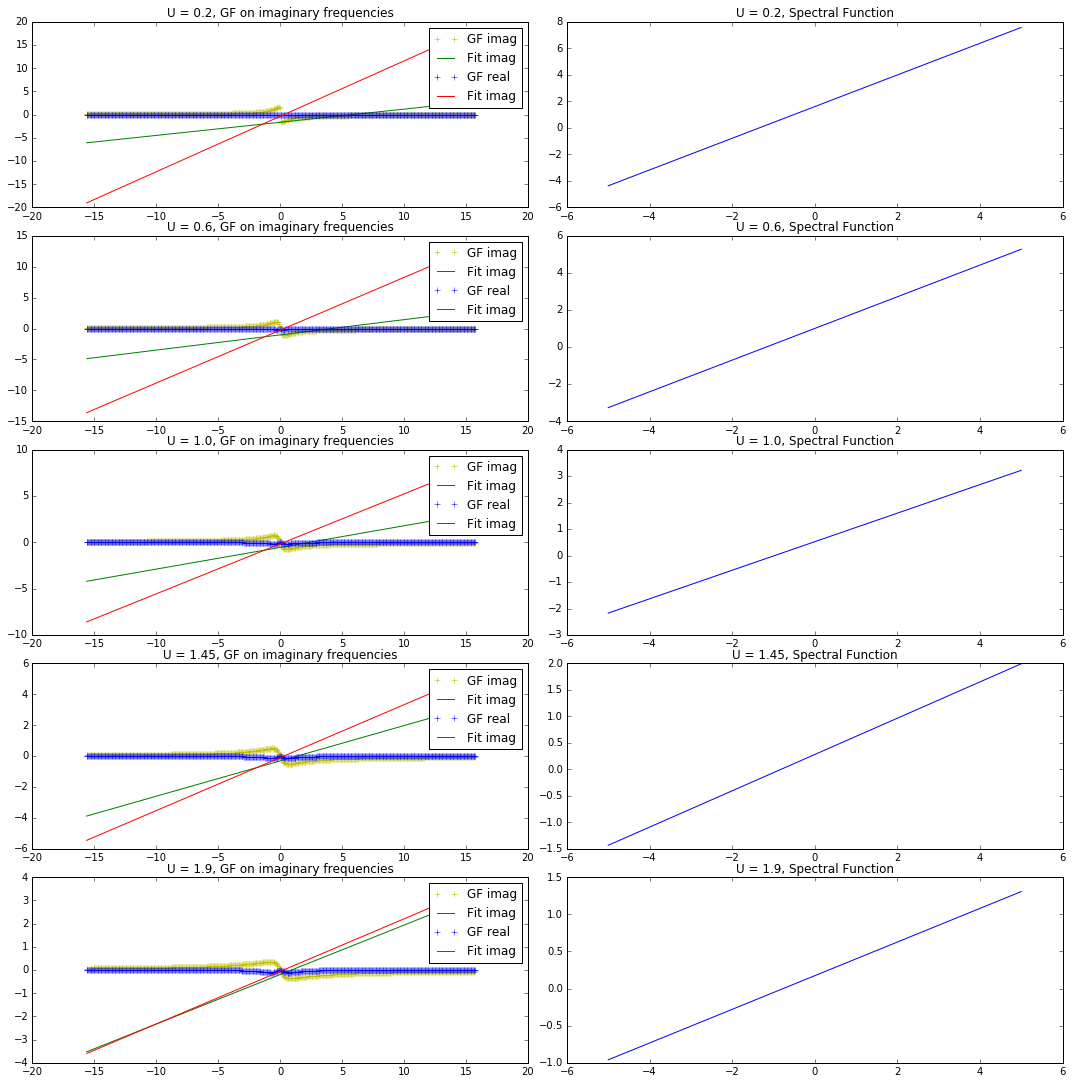

In [71]:
#step = 160
cut = 0.1
k = 2
#interstep = 2*k+1
eta = 0.1
plot_freq = np.linspace(-5.,5.,100)
my_freq = eta - 1j*plot_freq
#gf = 1./(1j*freq+2.)
fig, ax = plt.subplots(nrows=len(Glocs),ncols=2,figsize=(15,15))
fig.tight_layout()
for index in range(len(Glocs)):
    gf = Glocs[index]
    n = freq.size
    lower = 0
    upper = n
    freq_points = shift_cut_symmetric(freq,lower,upper,k)
    gf_points = shift_cut_symmetric(gf,lower,upper,k)
    # freq_points = freq[::step]
    #freq_points = np.fft.fftshift(freq)[lower:upper:interstep]
    # gf_points = gf[::step]
    #gf_points = np.fft.fftshift(gf)[lower:upper:interstep]
    a_list = get_a(freq_points, gf_points)
    spectral_func = -get_C(my_freq,freq_points,a_list).imag
    ordered_mats_freq = np.fft.fftshift(freq)
    fit_plot_freq = np.linspace(ordered_mats_freq[0],ordered_mats_freq[-1],5000)
    fit_func = get_C(fit_plot_freq,freq_points,a_list)
    ax[index,0].set_title("U = {}, GF on imaginary frequencies".format(U_list[index]))
    ax[index,0].plot(freq,Glocs[index].imag,'y+',label="GF imag")
    ax[index,0].plot(fit_plot_freq,fit_func.imag,'g-',label="Fit imag")
    ax[index,0].plot(freq,Glocs[index].real,'b+',label="GF real")
    ax[index,0].plot(fit_plot_freq,fit_func.real,'r-',label="Fit imag")
    ax[index,0].legend()  
    ax[index,1].set_title("U = {}, Spectral Function".format(U_list[index]))
    ax[index,1].plot(plot_freq,spectral_func,'-')

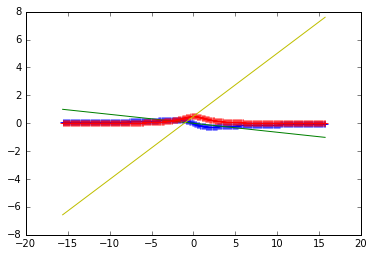

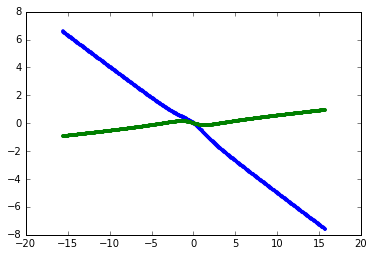

In [72]:
# check the interpolation for an easy example
step = 10
index = 2
gf = 1./(1j*freq+2.)
a_list = get_a(freq[::step], gf[::step])
CC = get_C(freq,freq[::step],a_list)
plt.plot(freq,gf.imag,'b+')
plt.plot(np.fft.fftshift(freq),np.fft.fftshift(CC.imag),'g-')
plt.plot(freq,gf.real,'r+')
plt.plot(np.fft.fftshift(freq),np.fft.fftshift(CC.real),'y-')
#plt.axis([-10,-9.5,0.015,0.025])
plt.figure()
plt.plot(freq, gf.real-CC.real, 'b.')
plt.plot(freq, gf.imag-CC.imag, 'g.')

In [73]:
# fit various Green's functions and plot the spectral function
G0 = 1. / ( 1j*freq + 2. )
g_0 = G0
Glocs = []
U_list = np.array([0.2,0.6,1.,1.45,1.9])
for U in U_list:
    for i in range(9):
        g_0, g_loc = DMFT_loop(g_0,U,0.3)
    Glocs.append(g_loc)

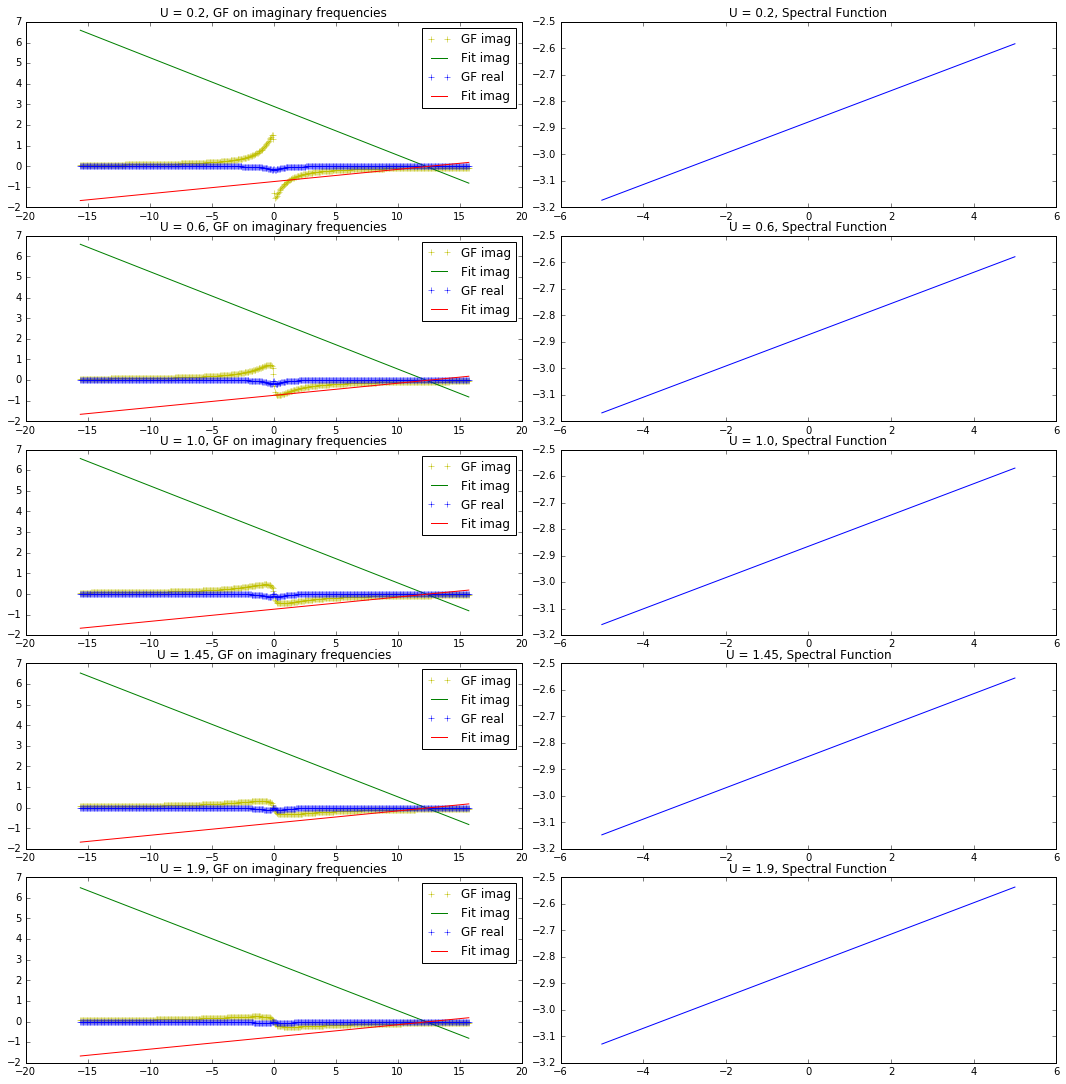

In [75]:
#step = 160
cut = 0.1
interstep = 5
eta = 0.1
plot_freq = np.linspace(-5.,5.,100)
my_freq = eta - 1j*plot_freq
#gf = 1./(1j*freq+2.)
fig, ax = plt.subplots(nrows=len(Glocs),ncols=2,figsize=(15,15))
fig.tight_layout()
for index in range(len(Glocs)):
    gf = Glocs[index]
    n = freq.size
    # freq_points = freq[::step]
    lower = int(np.floor(cut*n))
    upper = int(np.ceil((1.-cut)*n))
    freq_points = np.fft.fftshift(freq)[lower:upper:interstep]
    # gf_points = gf[::step]
    gf_points = np.fft.fftshift(gf)[lower:upper:interstep]
    a_list = get_a(freq_points, gf_points)
    spectral_func = -get_C(my_freq,freq_points,a_list).imag
    ordered_mats_freq = np.fft.fftshift(freq)
    fit_plot_freq = np.linspace(ordered_mats_freq[0],ordered_mats_freq[-1],100)
    fit_func = get_C(fit_plot_freq,freq_points,a_list)
    ax[index,0].set_title("U = {}, GF on imaginary frequencies".format(U_list[index]))
    ax[index,0].plot(freq,Glocs[index].imag,'y+',label="GF imag")
    ax[index,0].plot(fit_plot_freq,fit_func.imag,'g-',label="Fit imag")
    ax[index,0].plot(freq,Glocs[index].real,'b+',label="GF real")
    ax[index,0].plot(fit_plot_freq,fit_func.real,'r-',label="Fit imag")
    ax[index,0].legend()  
    ax[index,1].set_title("U = {}, Spectral Function".format(U_list[index]))
    ax[index,1].plot(plot_freq,spectral_func,'-')